<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/embeddings-retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robst Retraining of Airline Embeddings

_Keeping existing embeddings as stable as possible when chaning the model or adding new data_

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190511


In [0]:
# large images?
printing = False

## Step I: Preparing data

In [4]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  6670k      0 --:--:-- --:--:-- --:--:-- 6670k


In [0]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np


airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)

In [0]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)

routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [0]:
from tensorflow.keras.utils import to_categorical

# sequence of airlines encoded as a unique number
X = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = to_categorical(encoded_routes)

## Step II: Using Original 1-d Model to re-create existing embeddings

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ai/master/models/airline-embedding-v1.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2155k  100 2155k    0     0  5257k      0 --:--:-- --:--:-- --:--:-- 5244k


In [10]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

from tensorflow.keras.models import load_model
model = load_model('airline-embedding-v1.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 180,445
Trainable params: 180,445
Non-trainable params: 0
________________________________________________

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

europe_airlines = ['LH', 'BA', 'SK', 'KL', 'AF', 'FR', 'SU', 'EW', 'TP', 'BT', 'U2']
us_airlines = ['AA', 'US', 'UA', 'WN', 'DL', 'AS', 'HA']

In [0]:
samples = [airline_tokenizer.word_index[airline_code.lower()] for airline_code in europe_airlines + us_airlines]

In [0]:
from tensorflow.keras.models import Model

embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

In [0]:
original_embeddings = embedding_model.predict(X)

<Figure size 1440x360 with 0 Axes>

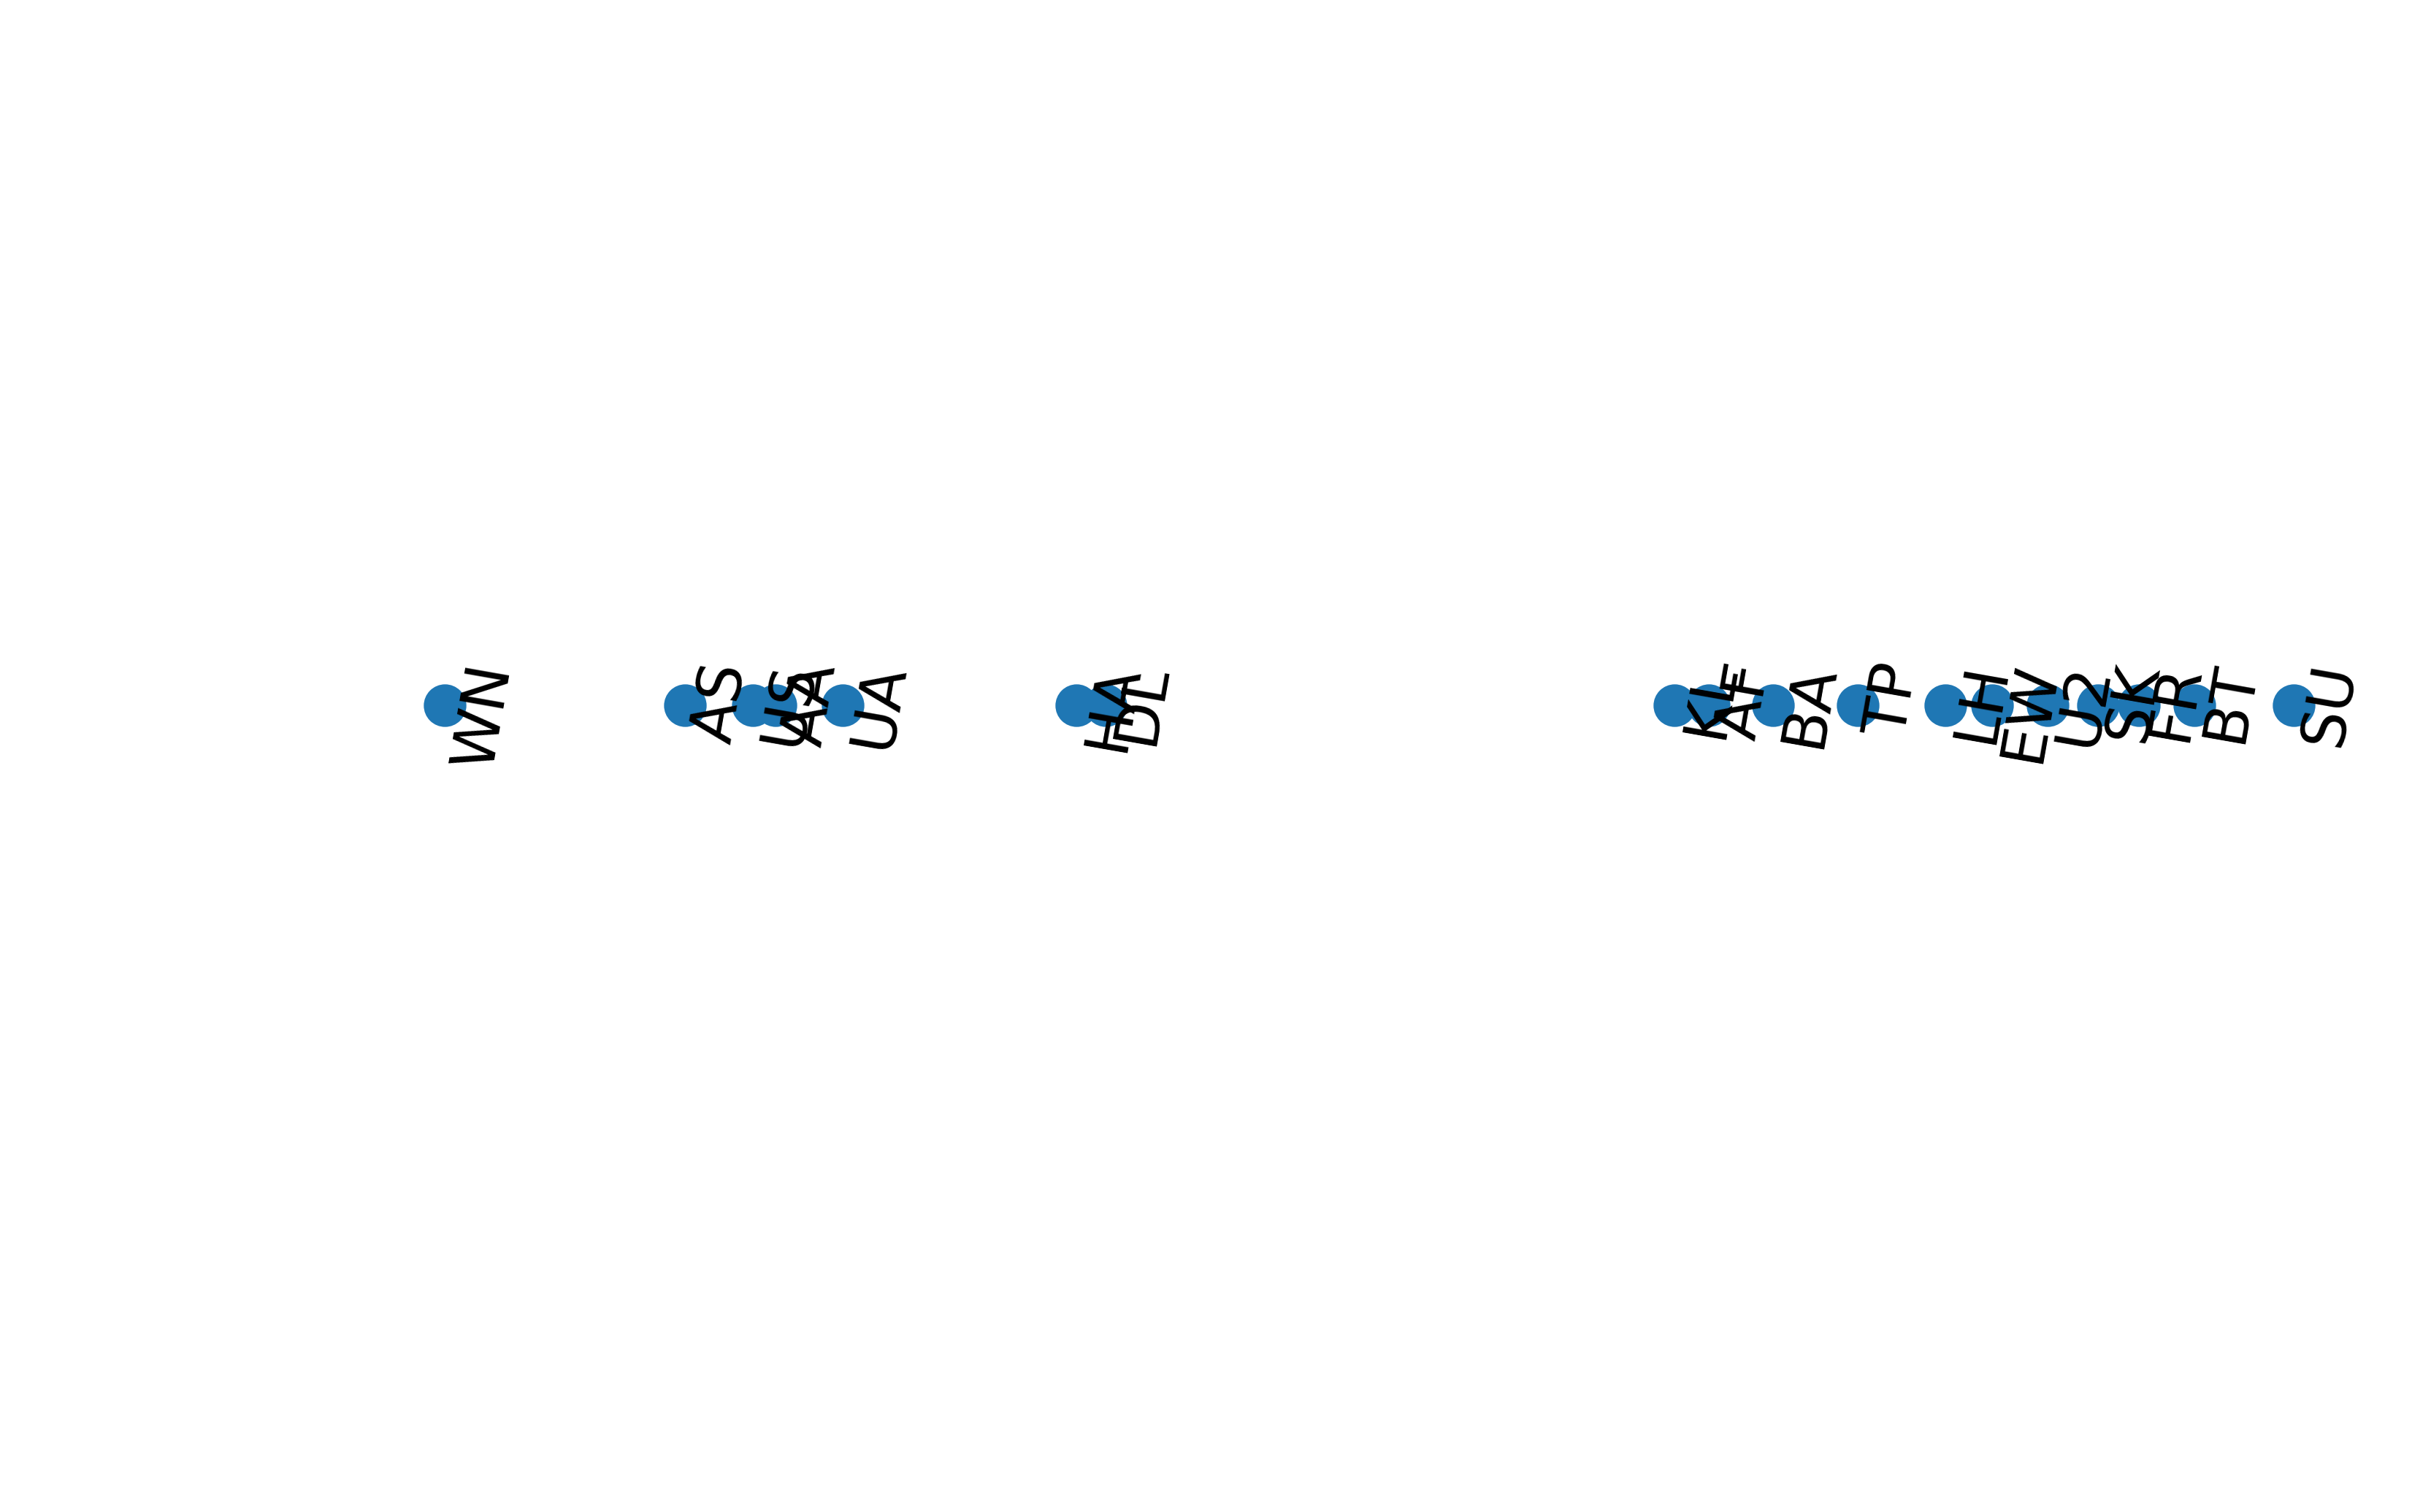

In [15]:
import matplotlib.pyplot as plt

if printing:
  plt.figure(figsize=(20,5))
  plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

In [0]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import cycle, islice


def cluster(embeddings_1d):
  # https://en.wikipedia.org/wiki/List_of_airline_codes
  # https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
  # https://www.tvlon.com/resources/airlinecodes.htm
  # https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

  airline_size = {
      'LH': 130, 'BA': 105, 'SK': 30, 'KL': 101, 'AF': 101, 'FR': 129, 'SU': 56, 'EW': 24, 'TP': 16, 'BT': 4, 'U2': 88, 'AA': 204, 'US': 204, 'UA': 158, 'WN': 164, 'DL': 192, 'AS': 46, 'HA': 12
  }
  sample_names = [airline_tokenizer.index_word[sample].upper() for sample in samples]
  sample_sizes = [airline_size[name] * 1e6 for name in sample_names]


  embeddings_1d_scaled = StandardScaler().fit_transform(embeddings_1d.reshape(-1, 1))
  sizes_for_samples_scaled = StandardScaler().fit_transform(np.array(sample_sizes).reshape(-1, 1))
  X = np.dstack((embeddings_1d_scaled.reshape(-1), sizes_for_samples_scaled.reshape(-1)))[0]
  X_scaled = StandardScaler().fit_transform(X)

  from sklearn.cluster import DBSCAN

  clf = DBSCAN(eps=0.5, min_samples=2)
  clf.fit(X_scaled)
  clusters = clf.labels_.astype(np.int)

  # last color is black to properly display label -1 as noise (black)
  colors = np.append(np.array(list(islice(cycle(['#AAAAFF', '#ff7f00', '#4daf4a',
                                   '#f781bf', '#a65628', '#984ea3',
                                   '#999999', '#e41a1c', '#dede00']),
                            int(max(clusters) + 1)))), ['#000000'])

  if printing:
    plt.figure(figsize=(20,5))
    plt.figure(dpi=600)

  plt.xlabel('Similarity by typical routes')
  plt.ylabel('Passengers')

  plt.scatter(embeddings_1d, sample_sizes, color=colors[clusters], s=200)
  for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
    plt.annotate(name, (x_pos,  y_pos), fontsize=18, color='grey')

<Figure size 1440x360 with 0 Axes>

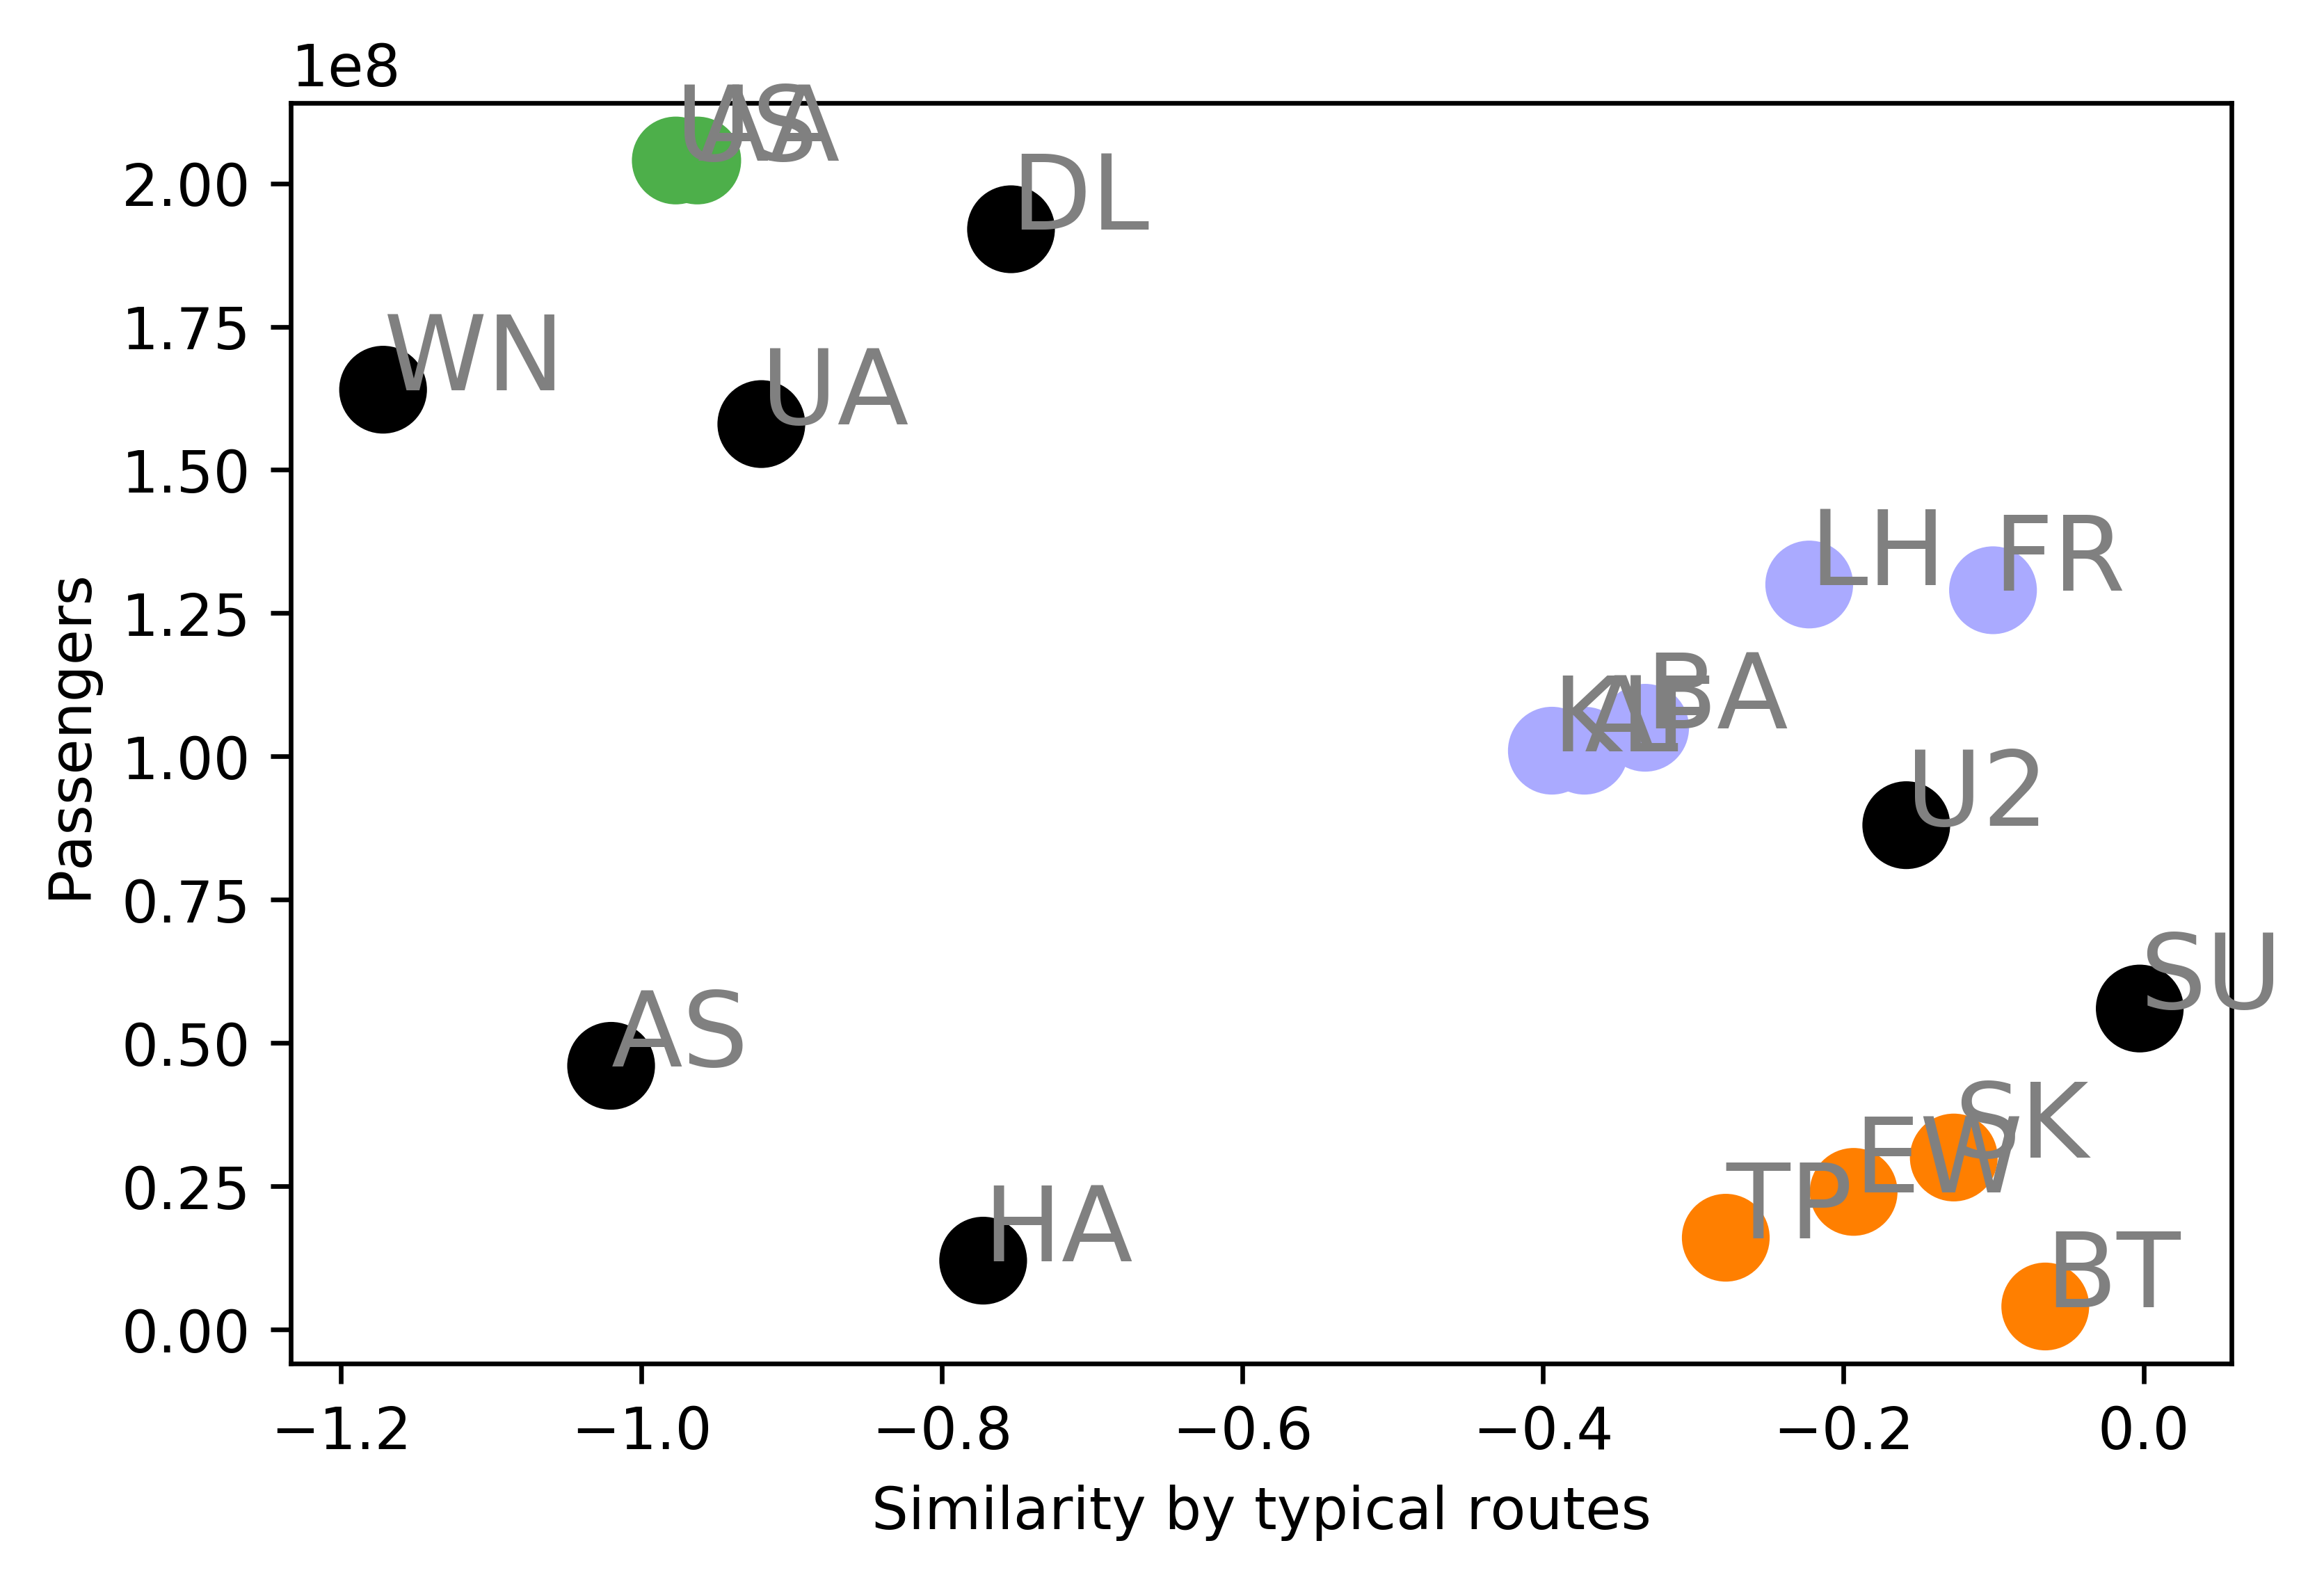

In [17]:
cluster(embeddings_1d)

## Step III: Convert original embedding model to functional API (as sequential will no longer be enough later)

https://keras.io/getting-started/functional-api-guide/



In [18]:
%%time

from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, SimpleRNN, Embedding, RepeatVector

from tensorflow.keras.initializers import glorot_normal
seed = 7

airlines = df['Airline'].unique()
output_dim = len(routes_tokenizer.word_index) + 1

input_dim = len(airlines) + 1
embedding_dim = 1

main_input = Input(shape=(1,), dtype='int32', name='main_input')

x = Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed))(main_input)

x = Flatten()(x)

x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

x = RepeatVector(2)(x)

x = SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

main_output = Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 50)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           1747

In [19]:
X.shape

(67663,)

In [20]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
67663/67663 [==============================] - 51s 753us/sample - loss: 6.3972 - accuracy: 0.0217
Epoch 2/20
67663/67663 [==============================] - 50s 745us/sample - loss: 5.7355 - accuracy: 0.0401
Epoch 3/20
67663/67663 [==============================] - 50s 734us/sample - loss: 5.4600 - accuracy: 0.0561
Epoch 4/20
67663/67663 [==============================] - 48s 712us/sample - loss: 5.2953 - accuracy: 0.0647
Epoch 5/20
67663/67663 [==============================] - 49s 730us/sample - loss: 5.1882 - accuracy: 0.0685
Epoch 6/20
67663/67663 [==============================] - 50s 732us/sample - loss: 5.1161 - accuracy: 0.0737
Epoch 7/20
67663/67663 [==============================] - 48s 711us/sample - loss: 5.0561 - accuracy: 0.0769
Epoch 8/20
67663/67663 [==============================] - 52s 769us/sample - loss: 5.0110 - accuracy: 0.0784
Epoch 9/20
67663/67663 [==============================] - 48s 714us/sample - loss: 4.9767 - accuracy: 0.0793
Epoch 10/20
67663/6

In [21]:
# we expect this to be substantially worse than the 2d version as the bottle neck now is much more narrow
loss, accuracy = model.evaluate(X, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 27s 395us/sample - loss: 4.7330 - accuracy: 0.0910


(4.732950602045272, 0.09103203)

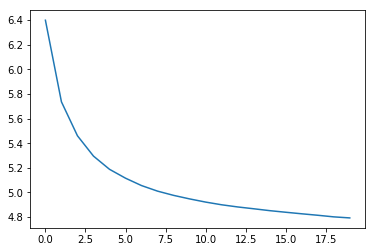

In [22]:
# plt.yscale('log')
plt.plot(history.history['loss'])

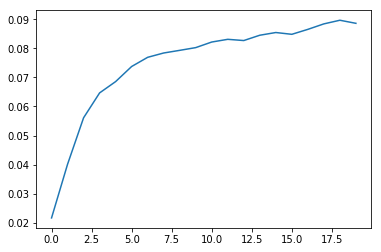

In [23]:
# plt.yscale('log')
plt.plot(history.history['accuracy'])

<Figure size 1440x360 with 0 Axes>

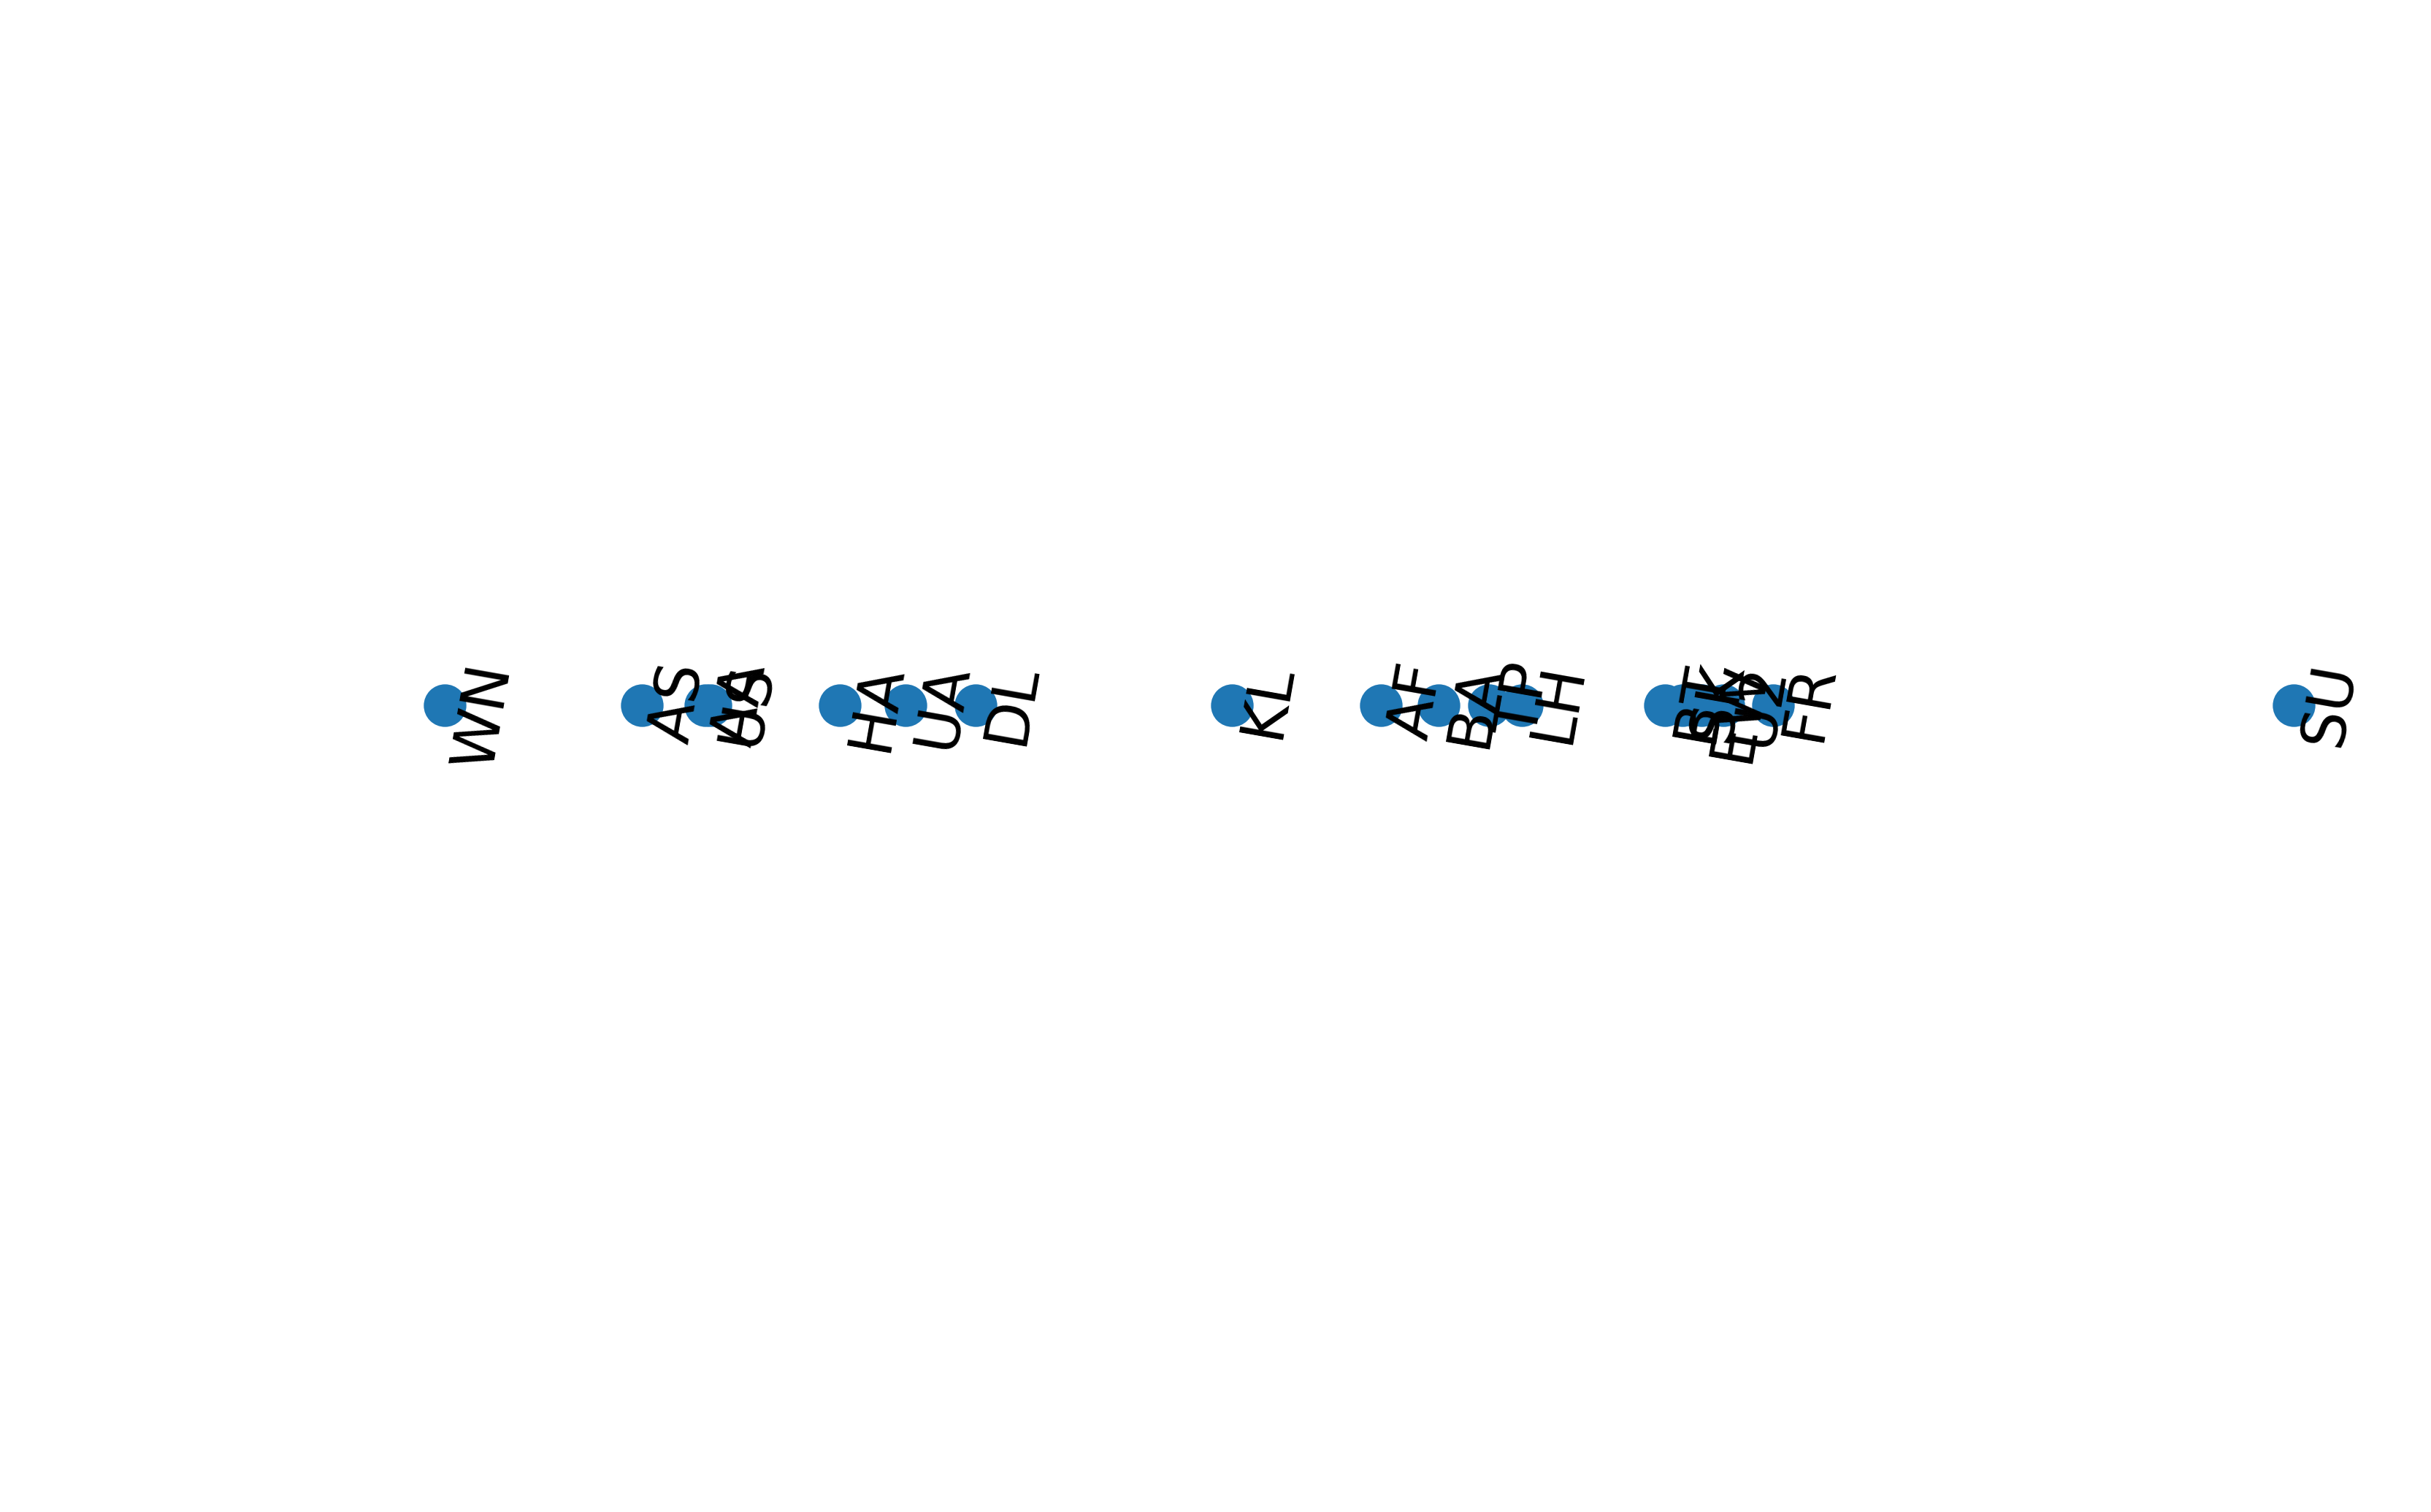

In [24]:
import numpy as np

embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

if printing:
  plt.figure(figsize=(20,5))
  plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

<Figure size 1440x360 with 0 Axes>

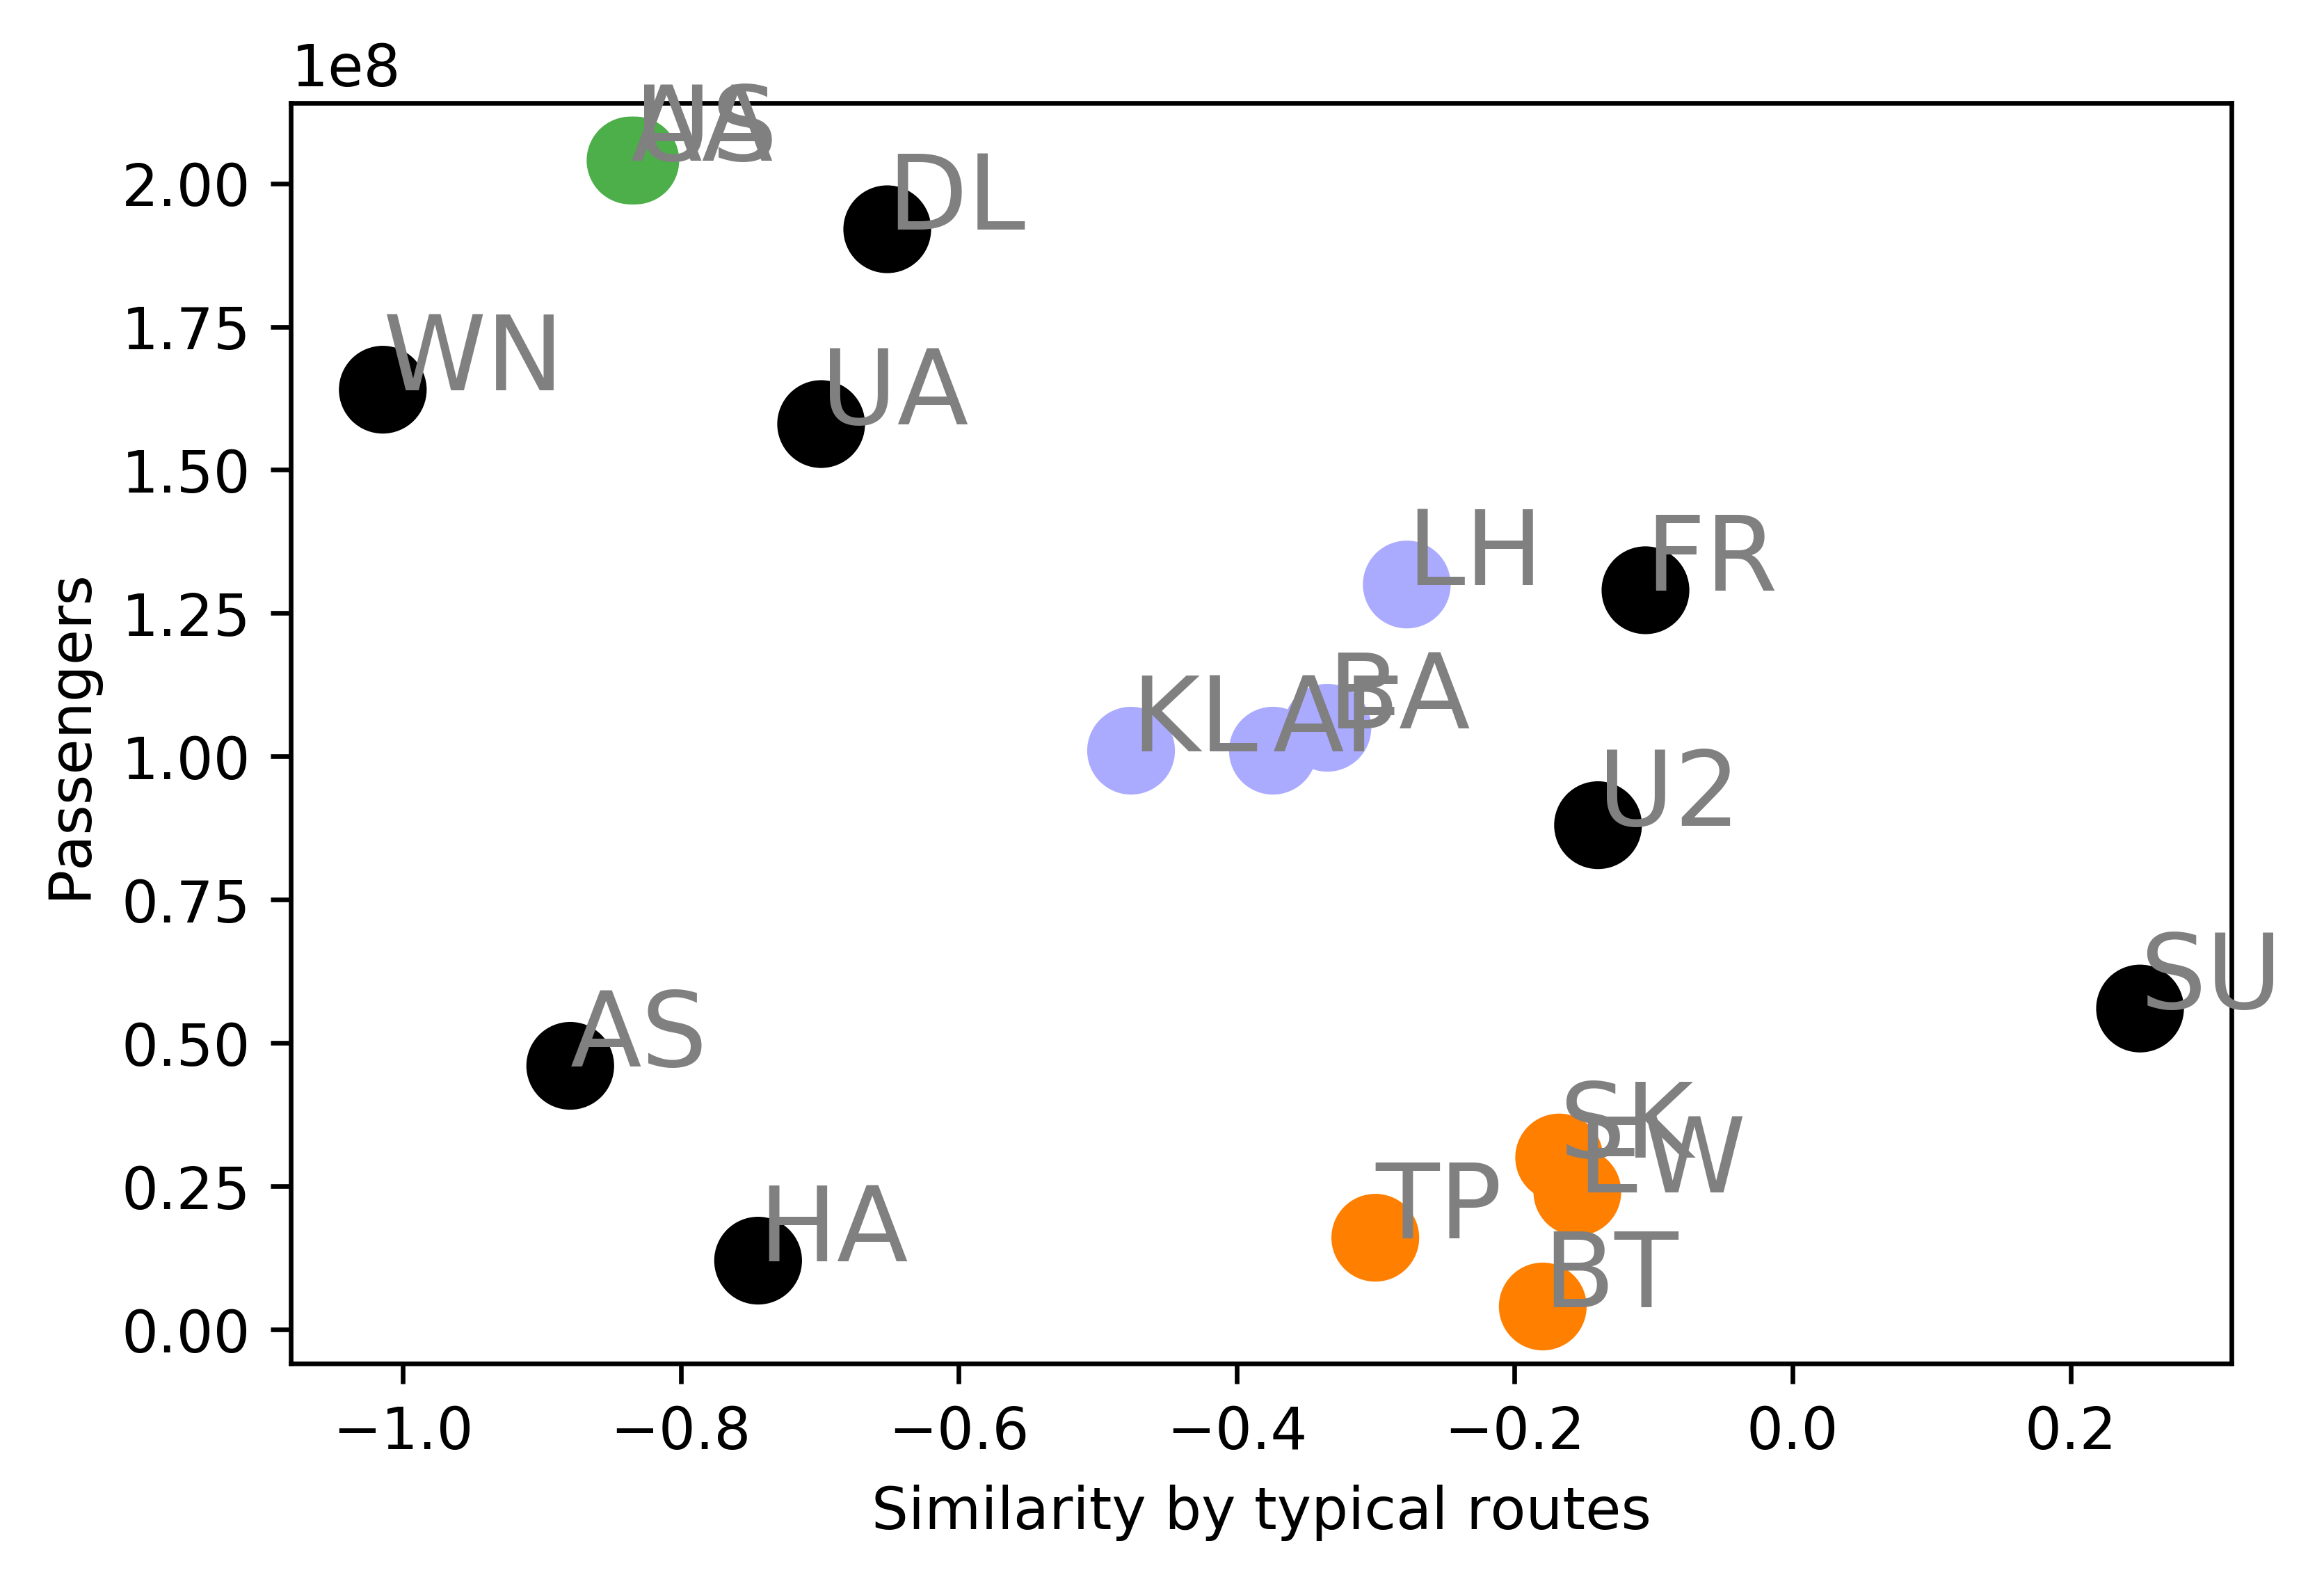

In [25]:
cluster(embeddings_1d)

## Step IV: Handle Model Change

In [26]:
%%time

from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, SimpleRNN, Embedding, RepeatVector
from tensorflow.keras.models import Model

from tensorflow.keras.initializers import glorot_normal
seed = 7

airlines = df['Airline'].unique()
output_dim = len(routes_tokenizer.word_index) + 1

input_dim = len(airlines) + 1
embedding_dim = 1

main_input = Input(shape=(1,), dtype='int32', name='main_input')

x = Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed))(main_input)

embedding = x # just the latent space as output

x = Flatten()(x)

x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)
# second dense layer
x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

x = RepeatVector(2)(x)

# less units (25 instead of 50)
x = SimpleRNN(units=25, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

main_output = Dense(units=output_dim, name='main_output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

model = Model(inputs=main_input, outputs=[main_output, embedding])

model.compile(optimizer='adam', 
              loss={'main_output': 'categorical_crossentropy', 'embedding': 'mae' },
              loss_weights={'main_output': .1, 'embedding': 1.},
             metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 25)             1900

In [27]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(x=X, 
                    y={'main_output': Y, 'embedding': original_embeddings},
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
67663/67663 [==============================] - 58s 862us/sample - loss: 0.9893 - main_output_loss: 6.3062 - embedding_loss: 0.3587 - main_output_accuracy: 0.0269 - embedding_accuracy: 0.0000e+00
Epoch 2/20
67663/67663 [==============================] - 59s 866us/sample - loss: 0.6922 - main_output_loss: 5.6449 - embedding_loss: 0.1277 - main_output_accuracy: 0.0552 - embedding_accuracy: 0.0000e+00
Epoch 3/20
67663/67663 [==============================] - 59s 872us/sample - loss: 0.6167 - main_output_loss: 5.3811 - embedding_loss: 0.0787 - main_output_accuracy: 0.0644 - embedding_accuracy: 0.0000e+00
Epoch 4/20
67663/67663 [==============================] - 59s 867us/sample - loss: 0.5722 - main_output_loss: 5.2666 - embedding_loss: 0.0455 - main_output_accuracy: 0.0649 - embedding_accuracy: 0.0000e+00
Epoch 5/20
67663/67663 [==============================] - 59s 865us/sample - loss: 0.5472 - main_output_loss: 5.2013 - embedding_loss: 0.0271 - main_output_accuracy: 0.0655 - e

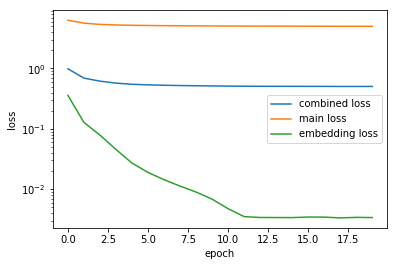

In [31]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['main_output_loss'])
plt.plot(history.history['embedding_loss'])

plt.legend(['combined loss', 'main loss', 'embedding loss'])


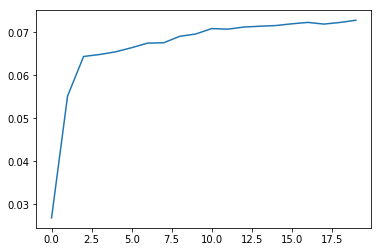

In [33]:
# plt.yscale('log')
plt.plot(history.history['main_output_accuracy'])

<Figure size 1440x360 with 0 Axes>

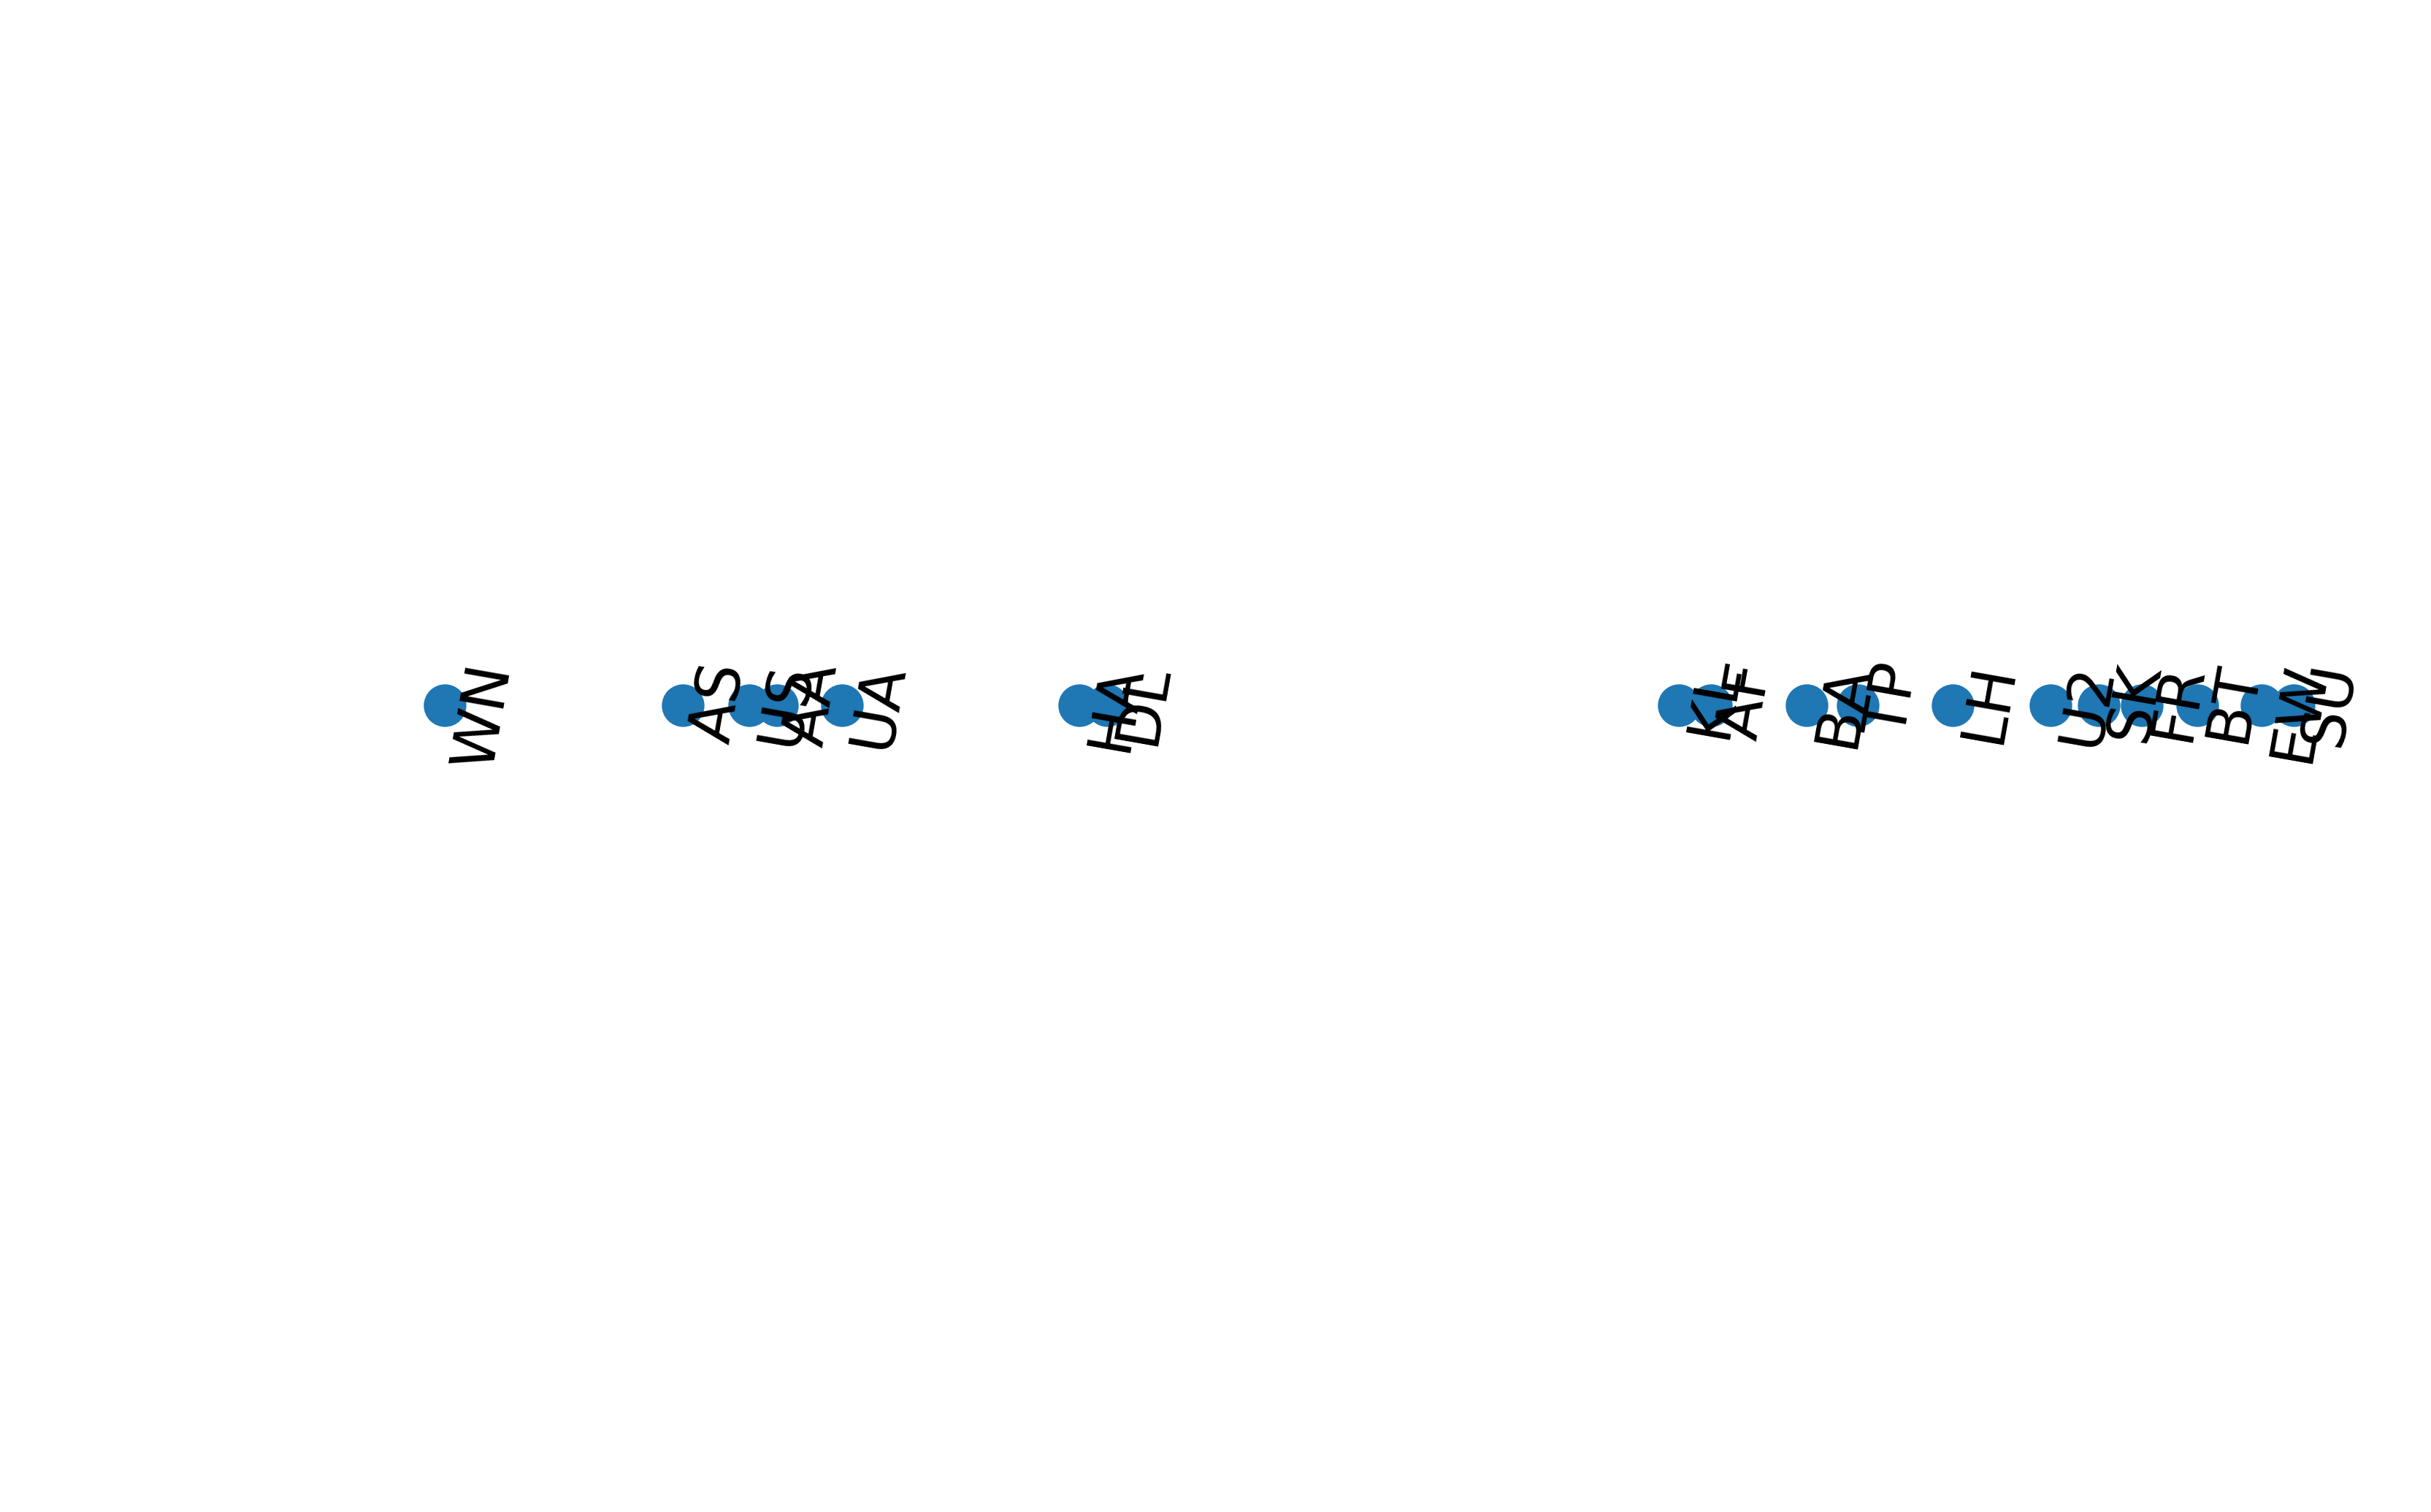

In [29]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

if printing:
  plt.figure(figsize=(20,5))
  plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

<Figure size 1440x360 with 0 Axes>

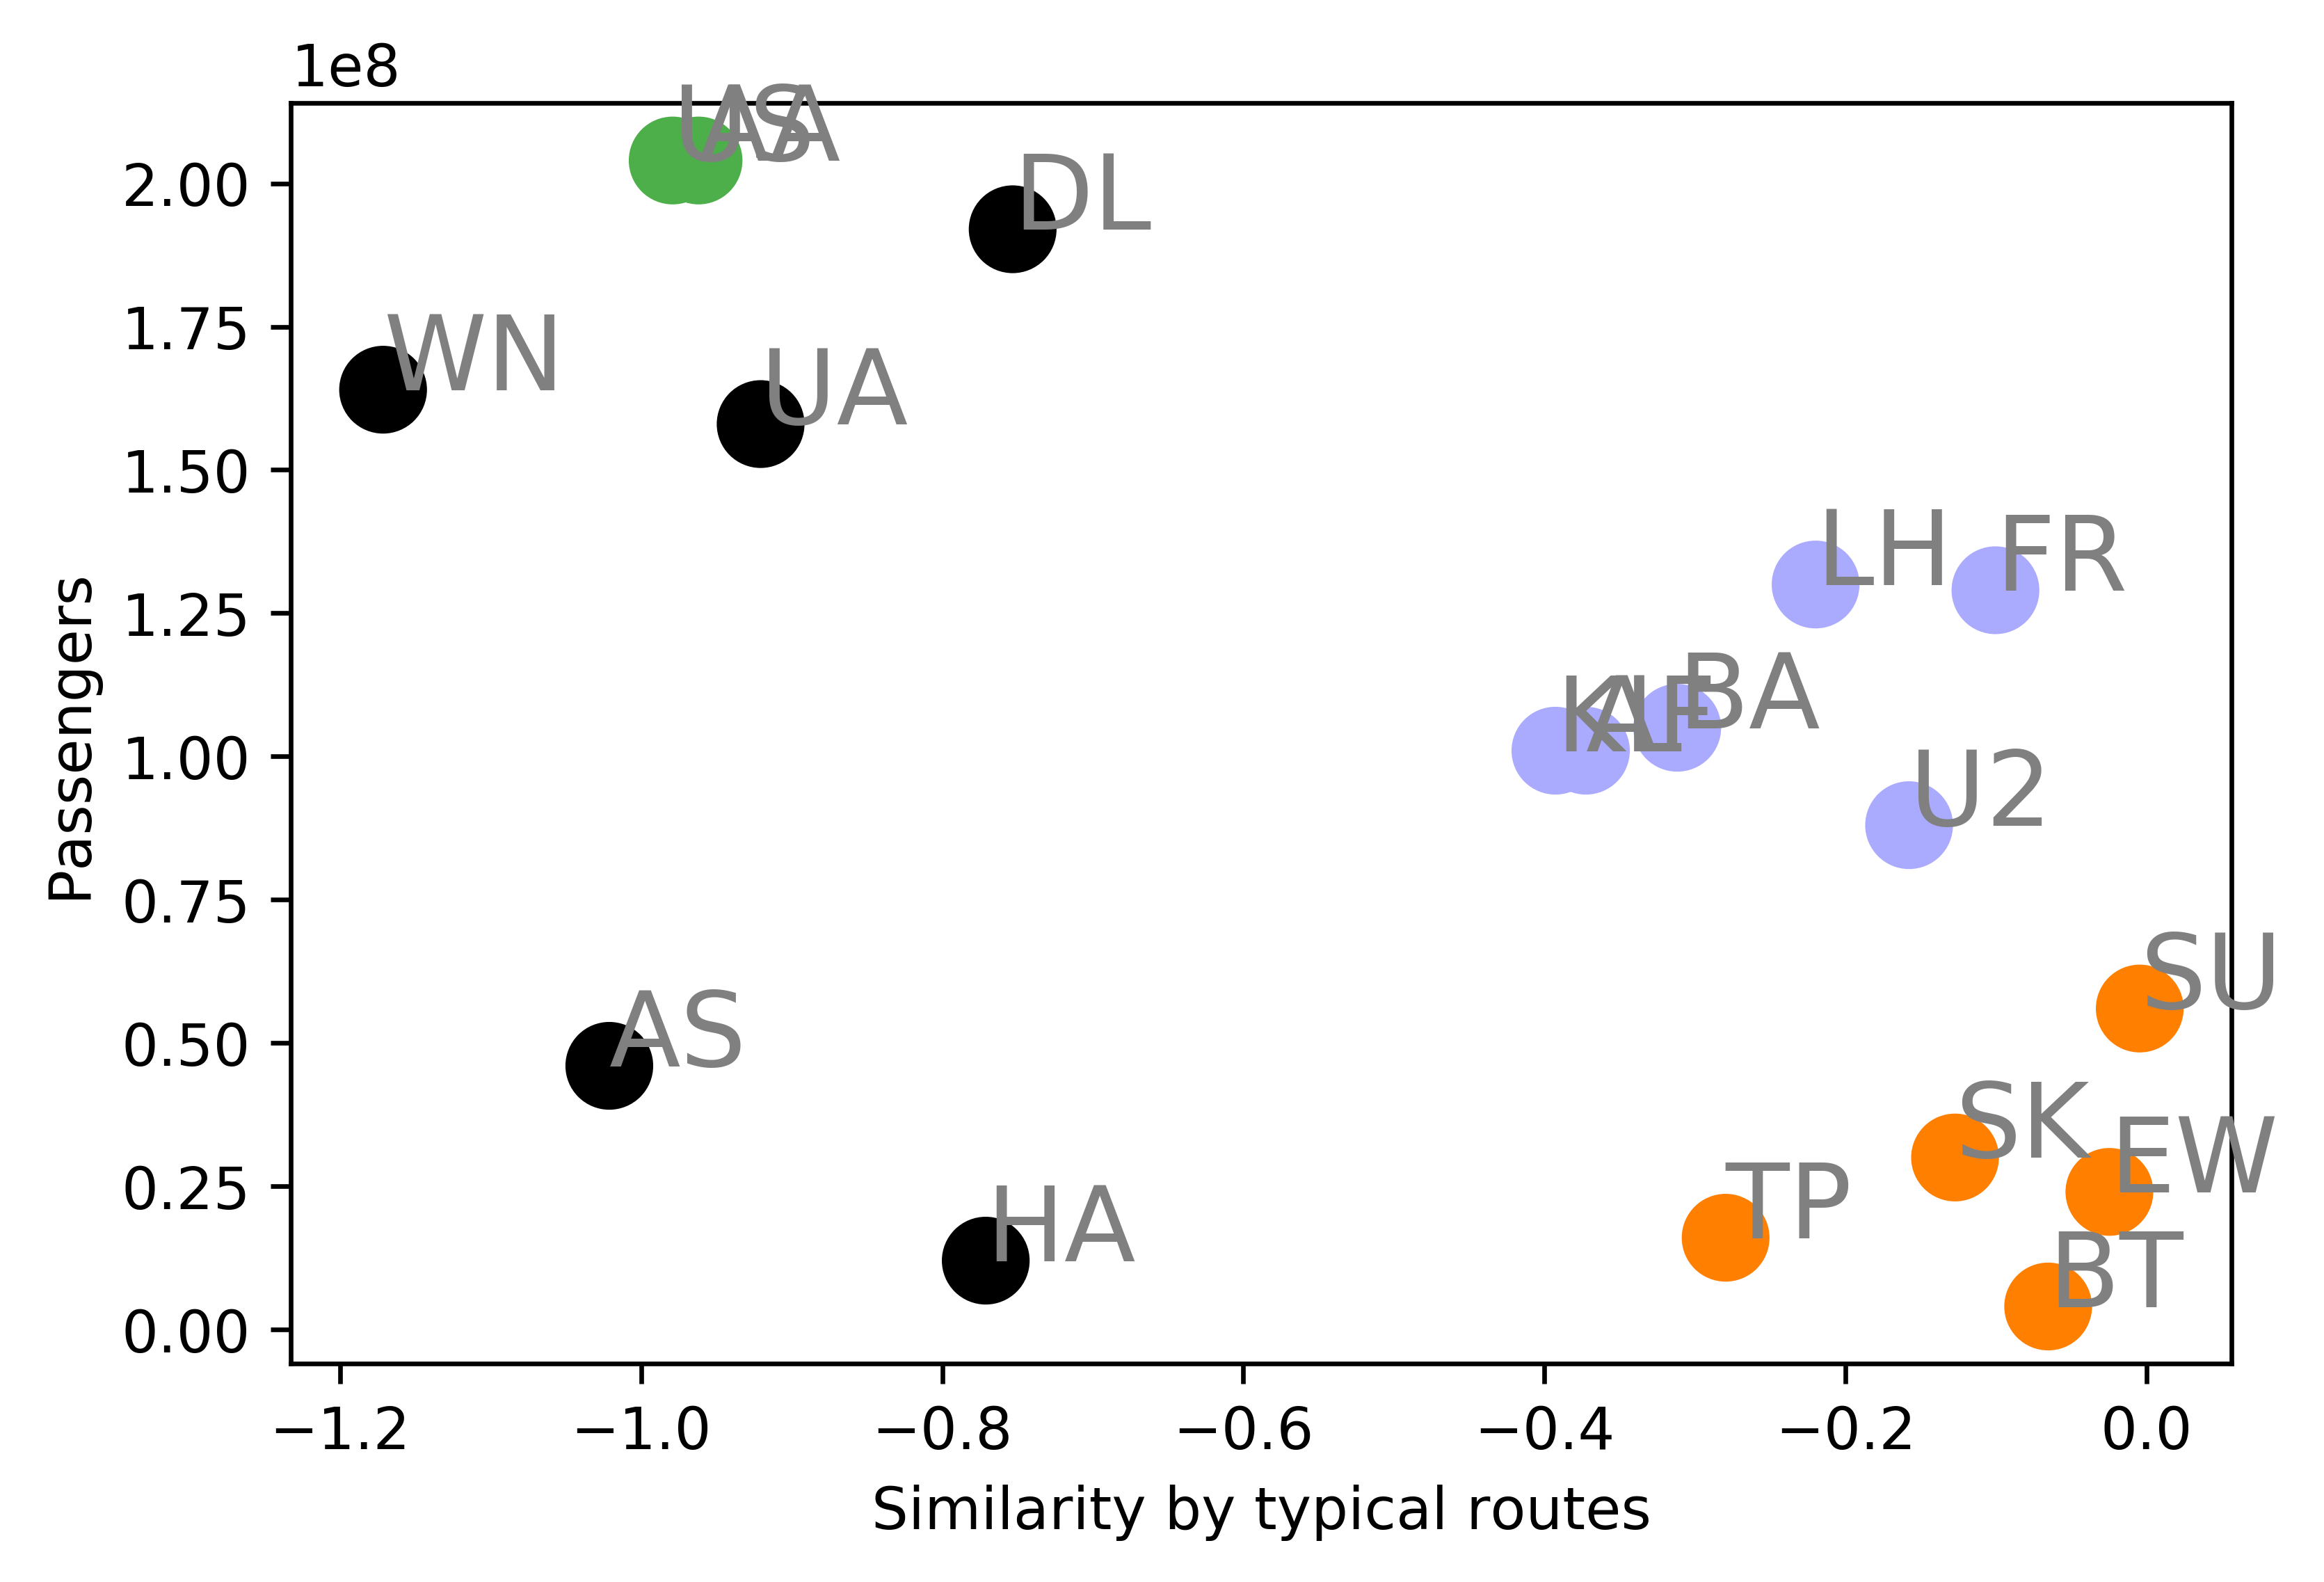

In [30]:
cluster(embeddings_1d)